# 🔄 Normalization Strategies
We apply three different normalization techniques to our QC-filtered dataset:
1. **Shifted Log Normalization** — Fast and effective for PCA and clustering.
2. **Scran Normalization** — Pooling-based size factor estimation, ideal for batch correction.
3. **Analytic Pearson Residuals** — Suitable for detecting highly variable genes and technical noise correction.

Each method is stored in a separate layer in the `AnnData` object.


In [7]:
import pandas as pd
import anndata as ad
%load_ext rpy2.ipython


# 📥 Load expression data
df = pd.read_parquet("../../data/sc_data/rnaseq_fpkm_qc_filtered.parquet")

# 🧹 Set 'SANGER_MODEL_ID' as index if not already
if "SANGER_MODEL_ID" in df.columns:
    df = df.set_index("SANGER_MODEL_ID")

# 🔬 Ensure all values are numeric
df = df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# ✅ Convert to AnnData
adata = ad.AnnData(X=df.values)
adata.obs_names = df.index
adata.var_names = df.columns

print("✅ AnnData created with shape:", adata.shape)


✅ AnnData created with shape: (1311, 37603)


## 1️⃣ Shifted Log Normalization
Rescales counts to the median library size across all samples and applies a log1p transformation. This is fast and effective for stabilizing variance for PCA and clustering.


In [8]:
import scanpy as sc
import numpy as np

# Normalize and log1p
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)


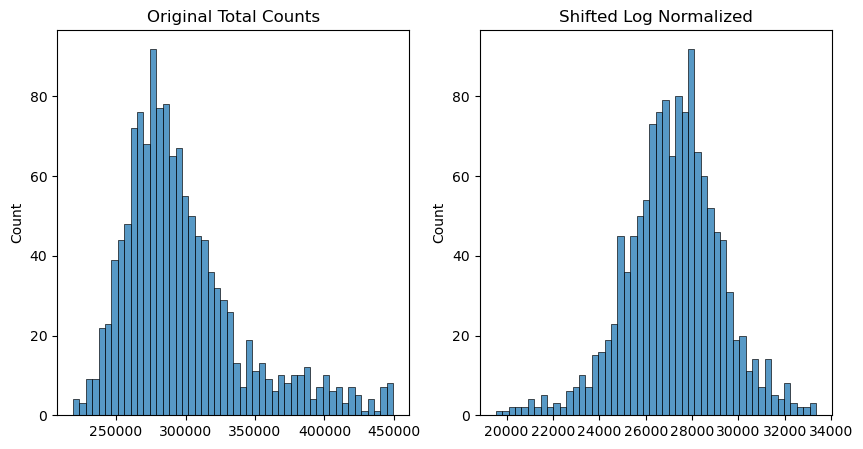

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["log1p_norm"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Shifted Log Normalized")
plt.show()


## 2️⃣ Scran Normalization
Uses a pooling and deconvolution strategy to estimate size factors and normalize expression data. Clustering improves performance.


In [10]:
# Scran preprocessing: cluster cells
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="scran_groups")


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# You can now safely convert pandas DataFrames to R
pandas2ri.activate()
from scipy.sparse import issparse

data_mat = adata.X.T
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()

ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["scran_groups"]


In [12]:
%%R -o size_factors
library(scran)
library(SingleCellExperiment)
library(BiocParallel)

size_factors = sizeFactors(
  computeSumFactors(
    SingleCellExperiment(list(counts=data_mat)),
    clusters=input_groups,
    min.mean=0.1,
    BPPARAM=MulticoreParam()
  )
)


R[write to console]: Error in library(scran) : there is no package called ‘scran’




Error in library(scran) : there is no package called ‘scran’


RInterpreterError: Failed to parse and evaluate line 'library(scran)\nlibrary(SingleCellExperiment)\nlibrary(BiocParallel)\n\nsize_factors = sizeFactors(\n  computeSumFactors(\n    SingleCellExperiment(list(counts=data_mat)),\n    clusters=input_groups,\n    min.mean=0.1,\n    BPPARAM=MulticoreParam()\n  )\n)\n'.
R error message: 'Error in library(scran) : there is no package called ‘scran’'

In [ ]:
adata.obs["size_factors"] = size_factors
scran_norm = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = sc.pp.log1p(scran_norm, copy=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["scran_normalization"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Scran Normalized")
plt.show()


## 3️⃣ Analytic Pearson Residuals
This method models technical noise with regularized negative binomial regression, providing residuals that preserve biological variation.


In [ ]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["pearson_residuals"] = analytic_pearson["X"]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["pearson_residuals"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Analytic Pearson Residuals")
plt.show()


📁 Saved log1p-normalized data to 'rnaseq_fpkm_log1p_normalized.parquet'


## 💾 Save Results
We store all normalization results in a single `.h5ad` file with different layers for easy downstream access.


In [ ]:
adata.write("normalized_all_layers.h5ad")
print("✅ Saved all normalized layers to 'normalized_all_layers.h5ad'")
